# Goal

This notebook checks model generalization performance on other dsets.

**With gratitude to**:
- https://github.com/mattiaspaul/OBELISK
-  https://github.com/kbressem/faimed3d/blob/main/examples/3d_segmentation.md

In [33]:
import os

try:
    taskid = int(os.getenv('SLURM_ARRAY_TASK_ID'))
    do_task = True
except:
    taskid = 0
    do_task = False

In [34]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [35]:
if not do_task:
    %load_ext autoreload
    %autoreload 2

# INFERENCE DATALOADER PARAMS
num_workers = 2

# ITEMS

from pathlib import Path
from helpers.items_constants import *

import SimpleITK as sitk
import pandas as pd

dsets_src    = f"{data_src}/PitMRdata"

# key,val = dset_name, path to top level dir
dset_dict = {
    "ABIDE"                  : f"{dsets_src}/ABIDE",
    "ABVIB"                  : f"{dsets_src}/ABVIB/ABVIB",
    "ADNI1_Complete_1Yr_1.5T": f"{dsets_src}/ADNI/ADNI1_Complete_1Yr_1.5T/ADNI",
    "AIBL"                   : f"{dsets_src}/AIBL/AIBL",
    "ICMB"                   : f"{dsets_src}/ICMB/ICBM",
    "PPMI"                   : f"{dsets_src}/PPMI/PPMI",
}

ppmi  = [i for i in cross_lbl_items if dset_dict["PPMI"] in i[0]]
icmb = [i for i in cross_lbl_items if "ICMB" in i[1]]
adni = [i for i in cross_lbl_items if "ADNI1_full" in i[1]]
aibl = [i for i in cross_lbl_items if "AIBL" in i[1]]
abvib = [i for i in cross_lbl_items if "ABVIB" in i[1]]

# print(len(ppmi))
# print(len(icmb))
# print(len(adni))
# print(len(aibl))
# print(len(abvib))
# print(len(test_items), len(valid_items), len(train_items))
print(len(cross_lbl_items))
print(len(ppmi)+len(icmb)+len(adni)+len(aibl)+len(abvib))
print(len(all_test_lbl_items))
print(len(cross_lbl_items)+len(test_items))

# Items as dict 
from pathlib import Path
from helpers.items_constants import *

#items  = all_test_lbl_items
items = all_test_lbl_items #ppmi, icmb, adni, aibl, abvib, test_items
itemsd = getd(items)

# print(f"n = {len(itemsd)}, test items = {len(test_items)}, other dsets = {len(cross_lbl_items)}")
# print(f"first item", itemsd[0])

import os
import shutil
import tempfile
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch

# print_config()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
418
418
484
484


In [36]:
# for model_fn in model_fns:
#     if os.path.isfile(f"{model_fn}/post_lcc_df.pkl"):
#         print(model_fn)

# Choices

In [37]:
# from helpers.general            import get_param
# from helpers.model_loss_choices import get_model, get_loss

# model_fns = sorted(Path(run_src).iterdir(), key=os.path.getmtime, reverse=True)
# todo = [str(model_fn) 
#         for model_fn in model_fns 
#         if not os.path.isfile(f"{str(model_fn)}/post_lcc_df.pkl") and "Mon_Aug_02" in str(model_fn)
#        ]

# print("TODO: ", len(todo))

# # params
# def get_param_default(name, prefix, suffix, default):
#     try:
#         return get_param(name, prefix, suffix)
#     except:
#         return default

# for model_fn in todo:
#     model_name = Path(model_fn).name

#     model_type = get_param(model_name, "model_", "_loss")

#     if "loss_bs" in model_name:
#         loss_type  = get_param(model_name, "loss_", "_bs")
#     else:
#         loss_type  = get_param(model_name, "loss_", "_full_res")

#     full_res   = get_param_default(model_name, "full_res_", "_pixdim", 96)
#     pixdim     = get_param_default(model_name, "pixdim_", "_do_simple", 1.5)
#     do_simple  = get_param_default(model_name, "do_simple_", "_do_flip", False)
#     do_flip    = get_param_default(model_name, "do_flip_", "_bs", True)

#     # tuple
#     pixdim    = tuple(float(pixdim) for _ in range(3))
#     full_res  = tuple(int(full_res) for _ in range(3))

#     # bool
#     do_flip   = do_flip == "True"
#     do_simple = do_simple == "True"

#     print(f"Model Name: {model_name}")
#     print(f"Model: {model_type}")
#     print(f"Loss : {loss_type}")
#     print(f"Pixd : {pixdim}")
#     print(f"Fullres : {full_res}")
#     print(f"Do flip: {do_flip}")
#     print(f"Do simple: {do_simple}")
    
#     print("*"*50 + "\n")

In [38]:
from helpers.general            import get_param
from helpers.model_loss_choices import get_model, get_loss

model_fns = sorted(Path(run_src).iterdir(), key=os.path.getmtime, reverse=True)
todo = [str(model_fn) 
        for model_fn in model_fns 
        if (not os.path.isfile(f"{str(model_fn)}/post_lcc_df.pkl") and \
                (os.path.isfile(f"{str(model_fn)}/figs/metrics.png")) and \
                ("Mon_Aug_02" in str(model_fn) or "Aug_03" in str(model_fn))
            )
       ]

print("TODO: ", len(todo))

model_idx  = taskid
model_name = Path(todo[model_idx]).name
print(f"Chosen: {model_name} (idx {model_idx})")

# params
def get_param_default(name, prefix, suffix, default):
    try:
        return get_param(name, prefix, suffix)
    except:
        return default

model_type = get_param(model_name, "model_", "_loss")

if "loss_bs" in model_name:
    loss_type  = get_param(model_name, "loss_", "_bs")
else:
    loss_type  = get_param(model_name, "loss_", "_full_res")
    
full_res   = get_param_default(model_name, "full_res_", "_pixdim", 96)
pixdim     = get_param_default(model_name, "pixdim_", "_do_simple", 1.5)
do_simple  = get_param_default(model_name, "do_simple_", "_do_flip", False)
do_flip    = get_param_default(model_name, "do_flip_", "_bs", True)

# tuple
pixdim    = tuple(float(pixdim) for _ in range(3))
full_res  = tuple(int(full_res) for _ in range(3))

# bool
do_flip   = do_flip == "True"
do_simple = do_simple == "True"

print(f"Model: {model_type}")
print(f"Loss : {loss_type}")
print(f"Pixd : {pixdim}")
print(f"Fullres : {full_res}")
print(f"Do flip: {do_flip}")
print(f"Do simple: {do_simple}")

#model_fn = "OBELISKHYBRID_log_cosh_dice_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_67_epochs_30_time_1626043621_Sun_Jul_07_2021_hr_18_min_47.pth"
# model_idx = 3
# model_name   = Path(model_fns[model_idx]).name
# print(f"Chosen: {model_name}")
# print(f"Prior: ", *[f"{idx}: {model_fn[len(run_src):]}" for idx,model_fn in enumerate(model_fns[:5])], sep="\n")

TODO:  0


IndexError: list index out of range

In [39]:
for fn in todo:
    model_name2 = Path(fn).name
    model_type2 = get_param(model_name2, "model_", "_loss")

    if "loss_bs" in model_name:
        loss_type2  = get_param(model_name2, "loss_", "_bs")
    else:
        loss_type2  = get_param(model_name2, "loss_", "_full_res")

    full_res2   = get_param_default(model_name2, "full_res_", "_pixdim", 96)
    pixdim2     = get_param_default(model_name2, "pixdim_", "_do_simple", 1.5)
    do_simple2  = get_param_default(model_name2, "do_simple_", "_do_flip", False)
    do_flip2    = get_param_default(model_name2, "do_flip_", "_bs", True)

    print(model_type2, loss_type2, "simple augs: ", do_simple2, "flip", do_flip2, "pixdim", pixdim2, "full_res", full_res2)

In [12]:
# from helpers.general import rm_prefix

# # check
# done = [str(model_fn) 
#         for model_fn in model_fns 
#         if os.path.isfile(f"{str(model_fn)}/post_lcc_df.pkl") and "Aug_03" in str(model_fn)
#        ]
# #print(*rm_prefix(done, prefix=run_src, do_sort=True), sep="\n")
# print(f"DONE: {len(done)}")

# for done_fn in done:
#     model_name = Path(done_fn).name
#     #print(model_name)
#     model_src = f"{run_src}/{model_name}"
#     check_post_df  = pd.read_pickle(f"{model_src}/post_lcc_df.pkl")
#     check_pre_df   = pd.read_pickle(f"{model_src}/pre_lcc_df.pkl")
#     check_stats_df = pd.read_pickle(f"{model_src}/stats_df.pkl")
    
#     if len(check_post_df) != len(itemsd):
#         print(done_fn)
#         print("Len", len(check_post_df))
#         print("*" * 50)
#     #display(check_post_df)
#     #display(check_pre_df)
#     #display(check_stats_df)

In [13]:
from helpers.general import rm_prefix
# print(*rm_prefix(todo, prefix=run_src), sep="\n")
print(*rm_prefix(todo, prefix=run_src, do_sort=True), sep="\n")

In [14]:
#import shutil
#print(os.path.isfile(f"{model_fns[0]}/model.pth"))
#shutil.rmtree(model_fns[0])

In [15]:
# import shutil
# for i,fn in enumerate(model_fns):
#     if not os.path.isfile(f"{fn}/model.pth"):
#         print(i,fn)
#         shutil.rmtree(fn)

In [16]:
# # Choices

# if not do_task:
#     model_names = {
#         # pixdim 1.5, full_res 96
#         "unet_bce": "model_UNET3D_loss_BCE_loss_bs_1_epochs_60_time_1627647477_Fri_Jul_30_2021_hr_08_min_17",
#         "obelisk_bce": "model_OBELISKHYBRID_loss_BCE_loss_bs_1_epochs_60_time_1627823459_Sun_Aug_01_2021_hr_09_min_10",
#         "vnet_bce": "model_VNET_loss_BCE_loss_bs_1_epochs_60_time_1627823149_Sun_Aug_01_2021_hr_09_min_05",
#         "unetr_bce": "model_UNETR_loss_BCE_loss_bs_1_epochs_60_time_1627830873_Sun_Aug_01_2021_hr_11_min_14",

#         "obelisk_bce_144": "model_OBELISKHYBRID_loss_BCE_loss_bs_1_epochs_60_time_1627865816_Sun_Aug_01_2021_hr_20_min_56",
#         "obelisk_dice_144": "model_OBELISKHYBRID_loss_DICE_loss_bs_1_epochs_60_time_1627865811_Sun_Aug_01_2021_hr_20_min_56",
#     }

#     model_name = model_names["obelisk_dice_144"]
#     full_res = 144
#     pixdim   = 1.0
#     do_flip = True

#     full_res = tuple(full_res for _ in range(3))
#     pixdim   = tuple(pixdim   for _ in range(3))

#     print(f"Full res: {full_res}, Pixdim: {pixdim}")

In [17]:
# clear cache
import gc
from helpers.general import print_hardware_stats

gc.collect()

if not str(device)=="cpu":
    torch.cuda.empty_cache()
    print_hardware_stats()
    

#GPU = 1, #CPU = 40
GPU Tesla V100-SXM2-16GB RAM Free: 14844MB | Used: 1316MB | Util   8% | Total 16160MB


In [18]:
# Transforms

from helpers.transforms import get_train_valid_transforms, get_train_valid_transforms_simple, monai_tfms2str

if do_simple:
    train_tfms, val_tfms = get_train_valid_transforms_simple(pixdim=pixdim, full_res=full_res)
else:
    train_tfms, val_tfms = get_train_valid_transforms(pixdim=pixdim, full_res=full_res, do_flip=do_flip)
    
print(f"val tfms: ", *val_tfms.transforms, sep="\n")


from helpers.general            import get_param
from helpers.model_loss_choices import get_model, get_loss

model   = get_model(model_type, full_res)
loss_fn = get_loss(loss_type) 

# print
print("Model name: ", model_name)
print(f"Model type: {model_type}. Loss type: {loss_type}.")
# Dataloaders

# Fastai + distributed training
from fastai              import *
from fastai.torch_basics import *
from fastai.basics       import *
from fastai.distributed  import *

# time it - 18s for 484 items
start = time.time()

# tls, dls, cuda
bs  = 5
tls = TfmdLists(itemsd, val_tfms)
dls = tls.dataloaders(bs=bs, after_batch=[], num_workers=num_workers, drop_last=False)

if not str(device)=="cpu":
    dls = dls.cuda()

# end timer
elapsed = time.time() - start
print(f"Elapsed time: {elapsed:.2f} s for {len(itemsd)} items")

# Learner
import gc
gc.collect()
from helpers.losses import dice_score
learn = Learner(dls       = dls, 
                model     = model, 
                loss_func = loss_fn,
                metrics   = dice_score)

# load model fname w/o .pth extension
learn.load(f"{run_src}/{model_name}/model")

if not str(device)=="cpu":
    learn.model = learn.model.cuda()
else:
    learn.model = learn.model.to(device)
#learn.model.eval()

# all predictions, 67 items, 4 workers, 15sec
# Elapsed: 326.07 s for 484 items.
# start = time.time()

# predictions = []
# targets     = []
# val_batch_iter = iter(dls.train)
# for n in range(int(len(itemsd[:20]) / bs)):
#     xb,yb = next(val_batch_iter)
#     preds = learn.model(xb.cpu())
#     predictions.append(preds)
#     targets.append(yb.cpu())
#     break
    
# #predictions, targets = learn.get_preds(dl=dls.train)
# elapsed = time.time() - start

# print(f"Elapsed: {elapsed:0.2f} s for {len(itemsd)} items.")

val tfms: 
UndoDict(['image', 'label'])
Model name:  model_OBELISKHYBRID_loss_DICE_loss_full_res_144_pixdim_1.0_do_simple_False_do_flip_True_bs_2_epochs_60_time_1628029376_Tue_Aug_03_2021_hr_18_min_22
Model type: OBELISKHYBRID. Loss type: DICE_loss.
Could not do one pass in your dataloader, there is something wrong in it
Elapsed time: 10.53 s for 484 items


In [19]:
# i = 6
# data = dls.train_ds[i]
# #print(data[0].shape, data[1].shape)
# # print(mask2bbox(np.asarray(data[1].squeeze(0))))

# # with torch.no_grad():
# #     outputs = model(data[0].unsqueeze(1).to(device)).cpu()

# # #print(outputs.shape)
# # print(mask2bbox(np.asarray(outputs.argmax(1).squeeze(0))))

# # input = outputs.argmax(1)
# target = data[1].unsqueeze(1)

# # iflat = input.contiguous().view(-1)
# tflat = target.contiguous().view(-1)
# # intersection = (iflat * tflat).sum()
# # dice_val = ((2. * intersection) /
# #            (iflat.sum() + tflat.sum()))

# # print("Dice", dice_score(outputs, data[0].unsqueeze(1)), dice_val)
# # print("*"*50)

# print(tflat.min())

In [20]:
# i = 6
# print(dls.train_ds[i][1].shape)
# print(val_tfms(itemsd[i])[1].shape)
# print(dls.train_ds[i][1].min(), val_tfms(itemsd[i])[1].min())

# assert np.array_equal(np.asarray(dls.train_ds[i][1]), np.asarray(val_tfms(itemsd[i])[1]))

In [21]:
# from monai.transforms import Compose
# i = 6
# t = val_tfms(itemsd[i])
# #t = Compose(val_tfms.transforms[:8])(itemsd[i])["label"]
# print(t[1].min())

In [22]:
# from helpers.losses import dice_score

In [23]:
# # check
# from helpers.preprocess import mask2bbox
# for i in range(484):
#     data = dls.train_ds[i]
#     #print(data[0].shape, data[1].shape)
#     #print(mask2bbox(np.asarray(data[1].squeeze(0))))

#     with torch.no_grad():
#         outputs = model(data[0].unsqueeze(1).to(device)).cpu()

#     #print(outputs.shape)
#     #print(mask2bbox(np.asarray(outputs.argmax(1).squeeze(0))))
    
#     dice_val = dice_score(outputs, data[1].unsqueeze(1))
    
#     input_mr   = data[0].squeeze(0).cpu()
#     output_seg = outputs.argmax(1).squeeze(0).cpu().byte()
#     target_seg = data[1].squeeze(1).squeeze(0).cpu().byte()

#     f = sitk.LabelOverlapMeasuresImageFilter()
#     f.Execute(torch2sitk(target_seg), torch2sitk(output_seg))

#     dice_val2 = f.GetDiceCoefficient()
#     false_neg_val = f.GetFalseNegativeError() 
#     false_pos_val = f.GetFalsePositiveError()
    
#     if false_neg_val > 1.0 or false_pos_val > 1.0:
# #     if dice_val.item() < 0.20:
#         print("idx ", i)
#         print("Dice", dice_val, dice_val2)
#         print("False pos", false_pos_val, "False neg", false_neg_val)
#         print(mask2bbox(np.asarray(data[1].squeeze(0))))
#         print(mask2bbox(np.asarray(outputs.argmax(1).squeeze(0))))
#         print("*"*50)

In [24]:
# f = sitk.LabelOverlapMeasuresImageFilter()
# f.Execute(torch2sitk(output_seg), torch2sitk(target_seg))

# label all zeros => huge proportion of labelled negative are falsely labelled negative => but no false positives
# n. labelled negative/ n. ground truth negative

# # False Neg: proportion ground truth positives that are labelled neg = 100% = (# label neg / total # gt pos)
# # False Pos: proportion ground truth negs that are labelled pos = 0% (# label pos / total # gt neg)
# dice_val_opp = f.GetDiceCoefficient()
# false_neg_val_opp = f.GetFalseNegativeError() 
# false_pos_val_opp = f.GetFalsePositiveError()

# # false pos rate = #false pos/(#false pos + #true neg)
# print(dice_val_opp, false_neg_val_opp, false_pos_val_opp)

In [25]:
# i = 127
# data = dls.train_ds[i]
# with torch.no_grad():
#     outputs = model(data[0].unsqueeze(1).to(device)).cpu()

In [26]:
# input_mr   = data[0].squeeze(0).cpu()
# output_seg = outputs.argmax(1).squeeze(0).cpu().byte()
# target_seg = data[1].squeeze(1).squeeze(0).cpu().byte()

# f = sitk.LabelOverlapMeasuresImageFilter()
# f.Execute(torch2sitk(target_seg), torch2sitk(output_seg))

# dice_val = f.GetDiceCoefficient()
# false_neg_val = f.GetFalseNegativeError() 
# false_pos_val = f.GetFalsePositiveError()

In [27]:
# print(dice_val)
# print(false_neg_val)
# print(false_pos_val)

In [28]:
# input_mr   = data[0].squeeze(0).cpu()
# output_seg = outputs.argmax(1).squeeze(0).cpu()
# target_seg = data[1].squeeze(1).squeeze(0).cpu()

# input_mr = np.asarray(input_mr)
# output_seg = np.asarray(output_seg)
    
# # bbox 112-115

# # target (57, 87, 77, 108, 62, 83)
# # pred (112, 115, 66, 68, 41, 44)

# # for sag_idx in range(112,115):
# #     fig, axes = plt.subplots(1,3)

# #     axes[0].imshow(np.rot90(input_mr[sag_idx]), cmap=plt.cm.gray)
# #     axes[0].imshow(np.rot90(output_seg[sag_idx]), alpha=0.5)

# #     axes[1].imshow(np.rot90(output_seg[sag_idx]))
# #     plt.show()

# for sag_idx in range(60,61):
#     fig, axes = plt.subplots(1,3)

#     axes[0].imshow(np.rot90(input_mr[sag_idx]), cmap=plt.cm.gray)
    
#     axes[1].imshow(np.rot90(input_mr[sag_idx]), cmap=plt.cm.gray)
#     axes[1].imshow(np.rot90(target_seg[sag_idx]), alpha=0.5)

#     axes[2].imshow(np.rot90(target_seg[sag_idx]))
#     plt.show()

In [29]:
from helpers.losses import dice, dice_score

In [30]:
# i = 6
# data = dls.train_ds[i]
# #print(data[0].shape, data[1].shape)
# print(mask2bbox(np.asarray(data[1].squeeze(0))))

# with torch.no_grad():
#     outputs = model(data[0].unsqueeze(1).to(device)).cpu()

# #print(outputs.shape)
# print(mask2bbox(np.asarray(outputs.argmax(1).squeeze(0))))

# input = outputs.argmax(1)
# target = data[1].unsqueeze(1)

# iflat = input.contiguous().view(-1)
# tflat = target.contiguous().view(-1)
# intersection = (iflat * tflat).sum()
# dice_val = ((2. * intersection) /
#            (iflat.sum() + tflat.sum()))

# print("Dice", dice_score(outputs, data[1].unsqueeze(1)), dice_val)
# print("*"*50)

# Post-processing

1. Largest Connect Label

In [31]:
# source sitk 36_Microscopy_Colocalization_Distance_Analysis.html
def get_largest_connected_component(binary_seg):
    # tensor to sitk
    #binary_seg = sitk.GetImageFromArray(binary_seg)
    
    # connected components in sitkSeg
    labeled_seg = sitk.ConnectedComponent(binary_seg)

    # re-order labels according to size (at least 1_000 pixels = 10x10x10)
    labeled_seg = sitk.RelabelComponent(labeled_seg, minimumObjectSize=1000, sortByObjectSize=True)

    # return segm of largest label
    binary_seg = labeled_seg == 1
    
    return binary_seg
    # sitk to tensor
    #return torch.tensor(sitk.GetArrayFromImage(binary_seg))
    
# eval metrics
# evaluate
filters = [sitk.LabelOverlapMeasuresImageFilter(), sitk.HausdorffDistanceImageFilter()]
methods = [
    [
        sitk.LabelOverlapMeasuresImageFilter.GetDiceCoefficient, 
        sitk.LabelOverlapMeasuresImageFilter.GetFalseNegativeError, 
        sitk.LabelOverlapMeasuresImageFilter.GetFalsePositiveError
    ],
    [sitk.HausdorffDistanceImageFilter.GetHausdorffDistance]
]

names = [
    ["dice", "false_neg", "false_pos"],
    ["hausdorff_dist"]
]

# d{"dice": x, "Hausdorff": y, "false pos": z}
def eval_measure(ground_truth, after_registration, names_todo=None):
    if isinstance(names_todo, str): names_todo = [names_todo]
        
    d = {}
    for f,method_list, name_list in zip(filters, methods, names):
        for m,n in zip(method_list, name_list):
            if not names_todo or n in names_todo:
                try:
                    #f.Execute(ground_truth, after_registration)
                    f.Execute(after_registration, ground_truth)
                    val = m(f)
                    
                except Exception as e:
                    print(e)
                    val = np.NaN
                d[n] = val
    return d

def torch2sitk(t): return sitk.GetImageFromArray(torch.transpose(t, 0, 2))
def sitk2torch(o): return torch.transpose(torch.tensor(sitk.GetArrayFromImage(o)), 0, 2)

# both pre and post lcc
def eval_measure2(label, pred, names_todo=None):
    label = torch2sitk(label.squeeze(0).byte())
    pred  = torch2sitk(pred.argmax(0).byte())
    pred_lcc = get_largest_connected_component(pred)
    return eval_measure(label, pred, names_todo), eval_measure(label, pred_lcc, names_todo)

In [32]:
# set model to evaluate model
learn.model.eval()

# device = torch.device("cuda:0")

# pre & post LCC
pre_df  = []
post_df = []

start = time.time()

# deactivate autograd engine and reduce memory usage and speed up computations
for data in dls.train:
#     start_small = time.time()

    # print("in loop")
    
    inputs = [i.to(device) for i in data[:-1]]
    labels = data[-1].cpu()

    # print("before no grad")
    with torch.no_grad():
        outputs = model(*inputs).cpu()
        
    # print("after no grad")
    # calculate metrics pre-LCC and post-LCC
    pre_metrics, post_metrics = zip(*[eval_measure2(labels[i], outputs[i])
                                      for i in range(len(labels))
                                     ])
    pre_df  += pre_metrics
    post_df += post_metrics
    
    # clean up memory
    del inputs
    del labels
    del outputs
    
    gc.collect()
    
    if str(device) != "cpu":
        torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
    # print_hardware_stats()

#     elapsed_small = time.time() - start_small
#     print(f"Elapsed: {elapsed_small:0.2f} s")

    # break

elapsed = time.time() - start
print(f"Elapsed: {elapsed:0.2f} s for {len(itemsd)} items.")
# y_true = y_true.cpu().numpy()  
# _, y_pred = torch.max(all_outputs, 1)
# y_pred = y_pred.cpu().numpy()
# y_pred_prob = F.softmax(all_outputs, dim=1).cpu().numpy()

KeyboardInterrupt: 

In [ ]:
# for df in (pre_df, post_df):
#     # non-intersecting
#     for col in ("false_neg",):
#         df.loc[df[col]>1.0, col] = 1.0

In [ ]:
# for df in (pre_df, post_df):
#     for col in ("dice", "false_neg", "false_pos", "hausdorff_dist"):
#         df.loc[df[col]=='-99', col] = np.NaN

In [ ]:
pre_df  = pd.DataFrame(pre_df)
post_df = pd.DataFrame(post_df)

# save
model_src = f"{run_src}/{model_name}"
pre_df.to_pickle(f"{model_src}/pre_lcc_df.pkl")
post_df.to_pickle(f"{model_src}/post_lcc_df.pkl")

for name_lst in names:
    for name in name_lst:
        pre_mean  = pre_df[name].mean()
        post_mean = post_df[name].mean()
        delta = post_mean - pre_mean
        print(f"{name}: diff = {delta:0.4f} ({pre_mean: 0.4f} ==> {post_mean:0.4f})")

In [32]:
# diff_dff = post_df - pre_df
# display(diff_dff[diff_dff["hausdorff_dist"].isna()])

In [33]:
# pd.set_option('display.max_rows', 230)
# display(diff_dff[diff_dff["false_pos"] < 0].sort_values(by=['dice'], ascending=False))

In [34]:
# diff_dff[diff_dff["dice"]!=0.0]["dice"].hist()

In [ ]:
# col = "false_pos"
# diff_dff[diff_dff[col]!=0.0][col].hist()

In [ ]:
# col = "false_neg"
# diff_dff[diff_dff[col]!=0.0][col].hist(), diff_dff[diff_dff[col]!=0.0][col].mean()

(<AxesSubplot:>, 0.7846837995383205)

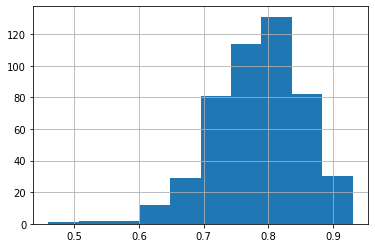

In [35]:
post_df["dice"].hist(), post_df["dice"].mean()

In [36]:
model_name

'model_VNET_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627978943_Tue_Aug_03_2021_hr_04_min_22'

In [37]:
np_indiv_dices = post_df["dice"].values

test_idxs  = [idx for idx,i in enumerate(items) if "ABIDE" in i[0]] 
ppmi_idxs  = [idx for idx,i in enumerate(items) if dset_dict["PPMI"] in i[0]]
icmb_idxs  = [idx for idx,i in enumerate(items) if "ICMB" in i[1]]
adni_idxs  = [idx for idx,i in enumerate(items) if "ADNI1_full" in i[1]]
aibl_idxs  = [idx for idx,i in enumerate(items) if "AIBL" in i[1]]
abvib_idxs = [idx for idx,i in enumerate(items) if "ABVIB" in i[1]]

# print(len(test_idxs))
# print(len(ppmi_idxs))
# print(len(icmb_idxs))
# print(len(adni_idxs))
# print(len(aibl_idxs))
# print(len(abvib_idxs))
# print(len(test_items), len(valid_items), len(train_items))

names = ["ABIDE", "PPMI", "ICMB", "ADNI", "AIBL", "ABVIB"]
idxs  = [test_idxs, ppmi_idxs, icmb_idxs, adni_idxs, aibl_idxs, abvib_idxs]

print_df = []

# overall dice
print_df.append({
    "dset":"Overall",
    "median_dice":np.median(np_indiv_dices),
    "mean_dice":np_indiv_dices.mean(),
    "std_dice":np_indiv_dices.std()
})

for name,name_idxs in zip(names, idxs):
    subset_idxs = np.array([np_indiv_dices[i] for i in name_idxs])
    print_df.append({"dset":name,"median_dice":np.median(subset_idxs),"mean_dice":subset_idxs.mean(),"std_dice":subset_idxs.std()})

print_df = pd.DataFrame(print_df)

# save
print_df.to_pickle(f"{model_src}/stats_df.pkl")

print_df = print_df.style.set_caption(f"{model_name}")
#display(print_df)

,dset,median_dice,mean_dice,std_dice
0,Overall,0.790150,0.784684,0.068106
1,ABIDE,0.779982,0.784664,0.066853
2,PPMI,0.794584,0.796741,0.066593
3,ICMB,0.786057,0.776571,0.063204
4,ADNI,0.794392,0.786449,0.067568
5,AIBL,0.791552,0.777907,0.080166
6,ABVIB,0.787818,0.781662,0.058581


In [38]:
print(model_name)

model_VNET_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627978943_Tue_Aug_03_2021_hr_04_min_22


In [40]:
# # check
# check_post_df  = pd.read_pickle(f"{model_src}/post_lcc_df.pkl")
# check_pre_df   = pd.read_pickle(f"{model_src}/pre_lcc_df.pkl")
# check_stats_df = pd.read_pickle(f"{model_src}/stats_df.pkl")
# display(check_post_df)
# display(check_pre_df)
# display(check_stats_df)

,dice,false_neg,false_pos,hausdorff_dist
0,0.785099,0.206190,0.223423,4.000000
1,0.769434,0.028537,0.363032,5.000000
2,0.764499,0.244717,0.226057,5.196152
3,0.847752,0.218248,0.074077,4.123106
4,0.743173,0.050343,0.389556,5.830952
...,...,...,...,...
479,0.813515,0.112400,0.249156,3.316625
480,0.746359,0.112157,0.356230,5.000000
481,0.787007,0.168078,0.253307,4.472136
482,0.741431,0.293437,0.220081,6.708204


,dice,false_neg,false_pos,hausdorff_dist
0,0.785099,0.206190,0.223423,4.000000
1,0.769434,0.028537,0.363032,5.000000
2,0.764499,0.244717,0.226057,5.196152
3,0.847752,0.218248,0.074077,4.123106
4,0.743173,0.050343,0.389556,5.830952
...,...,...,...,...
479,0.813515,0.112400,0.249156,3.316625
480,0.746359,0.112157,0.356230,5.000000
481,0.769915,0.168078,0.283489,17.000000
482,0.741431,0.293437,0.220081,6.708204


,dset,median_dice,mean_dice,std_dice
0,Overall,0.790150,0.784684,0.068106
1,ABIDE,0.779982,0.784664,0.066853
2,PPMI,0.794584,0.796741,0.066593
3,ICMB,0.786057,0.776571,0.063204
4,ADNI,0.794392,0.786449,0.067568
5,AIBL,0.791552,0.777907,0.080166
6,ABVIB,0.787818,0.781662,0.058581


In [ ]:
# targets     = torch.cat(y_true, dim=0)
# predictions = torch.cat(outputs, dim=0)

In [ ]:
# start = time.time()

# predictions = []
# targets     = []
# val_batch_iter = iter(dls.train)
# for n in range(int(len(itemsd) / bs)):
#     xb,yb = next(val_batch_iter)
#     preds = learn.model(xb.cpu())
#     predictions.append(preds)
#     targets.append(yb.cpu())
#     print("next", n)
    
#     del xb
#     del yb
#     del preds
    
# #predictions, targets = learn.get_preds(dl=dls.train)
# elapsed = time.time() - start

# print(f"Elapsed: {elapsed:0.2f} s for {len(itemsd)} items.")

In [ ]:
# # 30 sec for 67 test items (2 CPU workers)
# do_validate = False # True # False # True
# if do_validate:
#     start = time.time()
#     print(learn.validate(ds_idx=0))
#     elapsed = time.time() - start
#     print(f"Elapsed: {elapsed:0.2f} s for {(len(itemsd))} items.")
    
# print("Pred mask", predictions.shape, "Target (x = y = MR)", targets.shape)
# print("Pred mask", predictions[0].shape, "Target", targets[0].shape)

# do_masks = False # True # False # True
# if do_masks:
#     from helpers.preprocess import batch_get_bbox

#     # Elapsed 65.148959 s
#     start = time.time()

#     # get masks and probs
#     pred_masks = torch.argmax(predictions, dim=1).byte()
#     pred_bboxs = batch_get_bbox(pred_masks)
#     gt_bboxs   = batch_get_bbox(targets)
#     #pred_probs = np.asarray(predictions.softmax(1)[:,1].cpu())

#     elapsed = time.time() - start
#     print(f"Elapsed {elapsed:2f} s")

# Test set: Prediction Dice Distribution

In [ ]:
# from monai.losses import DiceLoss

# dice_loss = DiceLoss(
#     include_background=False, 
#     to_onehot_y=False, 
#     sigmoid=False, 
#     softmax=False, 
#     other_act=None, 
#     squared_pred=False, 
#     jaccard=False, 
#     reduction="none", 
#     smooth_nr=0, #1e-05, 
#     smooth_dr=0, #1e-05, 
#     batch=False)

# # dice_loss_soft = DiceLoss(
# #     include_background=False, 
# #     to_onehot_y=False, 
# #     sigmoid=True, 
# #     softmax=False, 
# #     other_act=None, 
# #     squared_pred=False, 
# #     jaccard=False, 
# #     reduction="none", 
# #     smooth_nr=0, #1e-05, 
# #     smooth_dr=0, #1e-05, 
# #     batch=False)

# start = time.time()

# indiv_dices = dice_loss(predictions.argmax(1).unsqueeze(1), targets)
# #indiv_dices = dice_loss_soft(predictions[:,1].unsqueeze(1), targets)
# indiv_dices = [1-dice_loss for dice_loss in indiv_dices]
# elapsed = time.time() - start

# print(f"Elapsed: {elapsed:0.2f} s for {len(targets)} items.")

In [ ]:
# start = time.time()

# # sort dices from low to high
# #sorted_dice_idxs  = sorted(range(len(indiv_dices)), key=lambda i:indiv_dices[i].item()) 
# np_indiv_dices = np.array([indiv_dices[i].item() for i in range(len(indiv_dices))])

# # plot
# fig1, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
# ax0.hist(np_indiv_dices, bins="auto")
# ax1.boxplot(np_indiv_dices)

# fig1.suptitle("Dice Score (ABIDE test set + Cross label items)")
# plt.show()

# # time
# elapsed = time.time() - start
# print(f"Elapsed: {elapsed:0.2f} s for {len(targets)} items.")

# test_idxs  = [idx for idx,i in enumerate(items) if "ABIDE" in i[0]] 
# ppmi_idxs  = [idx for idx,i in enumerate(items) if dset_dict["PPMI"] in i[0]]
# icmb_idxs  = [idx for idx,i in enumerate(items) if "ICMB" in i[1]]
# adni_idxs  = [idx for idx,i in enumerate(items) if "ADNI1_full" in i[1]]
# aibl_idxs  = [idx for idx,i in enumerate(items) if "AIBL" in i[1]]
# abvib_idxs = [idx for idx,i in enumerate(items) if "ABVIB" in i[1]]

# # print(len(test_idxs))
# # print(len(ppmi_idxs))
# # print(len(icmb_idxs))
# # print(len(adni_idxs))
# # print(len(aibl_idxs))
# # print(len(abvib_idxs))
# # print(len(test_items), len(valid_items), len(train_items))

# names = ["ABIDE", "PPMI", "ICMB", "ADNI", "AIBL", "ABVIB"]
# idxs  = [test_idxs, ppmi_idxs, icmb_idxs, adni_idxs, aibl_idxs, abvib_idxs]

# df = []

# # overall dice
# df.append({
#     "dset":"overall",
#     "median_dice":np.median(np_indiv_dices),
#     "mean_dice":np_indiv_dices.mean(),
#     "std_dice":np_indiv_dices.std()
# })

# for name,name_idxs in zip(names, idxs):
#     subset_idxs = np.array([indiv_dices[i].item() for i in name_idxs])
#     df.append({"dset":name,"median_dice":np.median(subset_idxs),"mean_dice":subset_idxs.mean(),"std_dice":subset_idxs.std()})

# import pandas as pd
# df = pd.DataFrame(df)

# model_src = f"{run_src}/{model_name}"
# df.to_pickle(f"{model_src}/test_dices.pkl")

# torch.save(predictions, f"{model_src}/test_preds.pt")
# torch.save(targets, f"{model_src}/test_targs.pt")
# torch.save(indiv_dices, f"{model_src}/test_dices.pt")

In [ ]:
# df

In [ ]:
# ax = df.plot.bar(x="dset",rot=0)

In [ ]:
# names = ["ABIDE", "PPMI", "ICMB", "ADNI", "AIBL", "ABVIB"]
# idxs  = [test_idxs, ppmi_idxs, icmb_idxs, adni_idxs, aibl_idxs, abvib_idxs]

# for name,name_idxs in zip(names, idxs):
#     subset_idxs = np.array([indiv_dices[i].item() for i in name_idxs])
#     print(name, ": ", "Median dice: ", np.median(subset_idxs), "Mean",subset_idxs.mean(), "+- std", subset_idxs.std())

In [ ]:
# np.median([1,2,3,4,5])

# Shape of Largest connected component

In [ ]:
# lccs = [sitk2torch(get_largest_connected_component(torch2sitk(x.byte()))) for x in pred_masks]

In [ ]:
# len(lccs), lccs[0].shape

In [ ]:
# lccs_all = torch.stack(lccs, dim=0)
# print(lccs_all.shape)

In [ ]:
# lccs_all.shape

In [ ]:
# lccs_all[:20].unsqueeze(1).shape

In [ ]:
# from helpers.isoperim import get_iso_ratio

In [ ]:
# start = time.time()
# pred_ratios = get_iso_ratio(predictions)
# elapsed = time.time() - start
# print(f"Elapsed: {elapsed:0.2f} s.")

In [ ]:
# start = time.time()
# lcc_ratios = get_iso_ratio(lccs_all.unsqueeze(1))
# elapsed = time.time() - start
# print(f"Elapsed: {elapsed:0.2f} s.")

In [ ]:
# targets.shape

In [ ]:
# start = time.time()
# target_ratios = get_iso_ratio(targets)
# elapsed = time.time() - start
# print(f"Elapsed: {elapsed:0.2f} s.")

In [ ]:
# fig, axes = plt.subplots(3,2, figsize=(12,12))
# axes[0,0].hist(np.asarray(target_ratios))
# axes[0,0].set_title("Target Isoperimetric ratio")
# axes[0,1].boxplot(np.asarray(target_ratios))

# axes[1,0].hist(np.asarray(ratios))
# axes[1,0].set_title("Largest Connected Component Isoperimetric ratio")
# axes[1,1].boxplot(np.asarray(ratios))

# diff = ratios - target_ratios
# axes[2,0].hist(np.asarray(diff))
# axes[2,0].set_title("Difference in Isoperimetric ratio")
# axes[2,1].boxplot(np.asarray(diff))

In [ ]:
# ratios

In [ ]:
# prediction_ratios = get_isoperimetric_ratio(*get_vol_sa(get_largest_connected_component()

In [ ]:
# target_ratios     = get_isoperimetric_ratio(*get_vol_sa(targets))
# prediction_ratios = get_isoperimetric_ratio(*get_vol_sa(predictions))

# _, axes = plt.subplots(1,2)
# axes[0].hist(np.asarray(target_ratios))
# axes[1].hist(np.asarray(prediction_ratios))
# axes[0].set_title("Target Isometric Ratio")
# axes[1].set_title("Pred Isometric Ratio")

# Convert

In [ ]:
# %%javascript
# IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

In [ ]:
# from nbconvert import HTMLExporter
# import codecs
# import nbformat

# notebook_name = nb_name
# output_file_name = notebook_name[:-6] + "_viz_probs_BCE_July_31" + '.html'

# exporter = HTMLExporter()
# output_notebook = nbformat.read(notebook_name, as_version=4)

# output, resources = exporter.from_notebook_node(output_notebook)
# codecs.open(output_file_name, 'w', encoding='utf-8').write(output)

# Isoperimetric ratios

# Probs

In [ ]:
# probs = predictions.softmax(1)[:,1]
# print(f"Probs", probs.shape)

In [ ]:
# from matplotlib import colors

# prob_cmap  = "GnBu" #"hot" https://matplotlib.org/stable/tutorials/colors/colormaps.html 
# bin_cmap1  = colors.ListedColormap(['white', 'yellow'])
# bin_cmap2  = colors.ListedColormap(['white', 'red'])

# for idx in sorted_dice_idxs[:10]:

#     print(f"Worst idx: {idx}. mr: {items[idx][0][len(data_src)+1:]}")
    
#     gt_bbox   = gt_bboxs[idx]
#     pred_bbox = pred_bboxs[idx]
    
#     gt_map    = targets[idx].squeeze()
#     prob_map  = probs[idx]
#     pred_mask = pred_masks[idx]

#     # max difference
#     d = torch.abs(gt_map-prob_map)

#     # along axis 0,1,2
#     a0 = torch.sum(torch.sum(d, dim=2), dim=1)
#     a1 = torch.sum(torch.sum(d, dim=2), dim=0)
#     a2 = torch.sum(torch.sum(d, dim=1), dim=0)
#     a0max, a0_idx = torch.max(a0), torch.argmax(a0)
#     a1max, a1_idx = torch.max(a1), torch.argmax(a1)
#     a2max, a2_idx = torch.max(a2), torch.argmax(a2)
    
#     # plot
#     fig, axes = plt.subplots(3,4, figsize=(12,12))
#     for i in range(3):
#         max_diff_idx = [a0_idx, a1_idx, a2_idx][i]
        
#         gt_slice, prob_slice, pred_slice = [np.take(np.asarray(m), max_diff_idx, axis=i) for m in (gt_map, prob_map, pred_mask)]
        
#         axes[i,0].imshow(gt_slice,   cmap=bin_cmap1)
#         axes[i,0].imshow(pred_slice, cmap=bin_cmap2, alpha=0.5)
#         axes[i,1].imshow(gt_slice,   cmap=bin_cmap1)
#         im  = axes[i,2].imshow(prob_slice, cmap=prob_cmap, interpolation='nearest')  
#         im2 = axes[i,3].imshow(np.log(prob_slice), cmap=prob_cmap, interpolation='nearest')  

#         axes[i,0].set_title(f"Slice {max_diff_idx} (Axis {i})")
#         axes[i,1].set_title(f"GT map")
#         axes[i,2].set_title(f"Prob map")
#         axes[i,3].set_title(f"Log Prob map")
        
#         # colorbar
#         fig.colorbar(im,  ax=axes[i,2])
#         fig.colorbar(im2, ax=axes[i,3])

#     plt.show()

# Viz worst

In [ ]:
# import SimpleITK as sitk
# from helpers.viz import viz_axis, viz_compare_inputs, viz_compare_outputs

In [ ]:
# from helpers.general import round_tuple

In [ ]:
# worst_idx = low_dice_idxs[0]
# best_idx  = sorted_dice_idxs[-1]
# print("Worst. Idx = ", worst_idx, "Dice: ", indiv_dices[worst_idx], items[worst_idx][0]); print()
# print("Best. Idx = ", best_idx, "Dice: ",   indiv_dices[best_idx], items[best_idx][0])

# # get dirs
# worst_fn = items[worst_idx][0]
# best_fn  = items[best_idx][0]

# print(f"Worst fname: {worst_fn[len(data_src):]}"); print()
# print(f"best fname: {best_fn[len(data_src):]}")

# for fn in (worst_fn, best_fn):
#     # get stated direction
#     sitk_obj = sitk.ReadImage(fn, sitk.sitkFloat32)
#     sitk_dir = sitk_obj.GetDirection()

#     # get stated orientation
#     orient = sitk.DICOMOrientImageFilter()
#     sitk_ori = orient.GetOrientationFromDirectionCosines(sitk_dir)
    
#     # print
#     print(f"Dir {round_tuple(sitk_dir)}, Ori {sitk_ori}")

# def get_input(idx):
#     mr1,mk1 = tls[idx]
#     return mr1.squeeze(), mk1.squeeze()

# input1 = get_input(worst_idx)
# input2 = get_input(best_idx)
    
# for axis in range(3):
#     viz_compare_inputs(input1, input2, axis=axis)

In [ ]:
# from helpers.viz import get_mid_range

In [ ]:
# from matplotlib import colors
# bin_cmap2  = colors.ListedColormap(['white', 'yellow'])

In [ ]:
# # intensity

# worst_idxs = sorted_dice_idxs[:5]
# best_idxs  = sorted_dice_idxs[-5:]

# _, axes = plt.subplots(10,3, figsize=(6,12))

# for i in range(5):
#     w_idx = worst_idxs[i]
#     b_idx = best_idxs[i]
    
#     input1 = get_input(w_idx)
#     input2 = get_input(b_idx)

#     bbox1 = gt_bboxs[w_idx]
#     bbox2 = gt_bboxs[b_idx]
    
#     # plot
#     for axis in range(3):
#         start_idx1, end_idx1 = get_mid_range(bbox1, axis, nslices=1)
#         start_idx2, end_idx2 = get_mid_range(bbox2, axis, nslices=1)
        
#         # WORST: mid-slice in axis
#         axes[2*i, axis].imshow(np.take(np.rot90(input1[0]), start_idx1, axis=axis)) #, cmap=plt.cm.gray)
#         #axes[2*i, axis].imshow(np.take(np.rot90(input1[1]), start_idx1, axis=axis), cmap=bin_cmap2, alpha=0.5)
        
#         # BEST: mid-slice in axis
#         axes[2*i+1, axis].imshow(np.take(np.rot90(input2[0]), start_idx2, axis=axis)) #, cmap=plt.cm.gray)
#         #axes[2*i+1, axis].imshow(np.take(np.rot90(input2[1]), start_idx2, axis=axis), cmap=bin_cmap2, alpha=0.5)

# plt.show()

In [ ]:
# # intensity hist

# worst_idxs = sorted_dice_idxs[:5]
# best_idxs  = sorted_dice_idxs[-5:]

# #fig = plt.figure(constrained_layout=True)

# fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
# fig.suptitle('MR Intensity Histogram')

# axes[0,0].set_yscale('log')
# axes[0,2].set_title("Worst")
# axes[1,2].set_title("Best")
# # subfigs = fig.subfigures(nrows=2, ncols=1)
# # subfigs[0].suptitle(f'Worst');
# # subfigs[1].suptitle(f'Best')

# # axs = []
# # for subfig in subfigs:
# #     # create 1x3 subplots per subfig
# #     axs.append(subfig.subplots(nrows=1, ncols=5))
# # axs = np.asarray(axs)    
# # #, axes = plt.subplots(2,5, figsize=(6,12))

# for i in range(5):
#     w_idx = worst_idxs[i]
#     b_idx = best_idxs[i]
    
#     input1 = get_input(w_idx)
#     input2 = get_input(b_idx)

#     mr1, mk1 = input1
#     mr2, mk2 = input2
    
#     mr1, mk1 = np.asarray(mr1), np.asarray(mk1)
#     mr2, mk2 = np.asarray(mr2), np.asarray(mk2)
    
#     # plot
    
#     axes[0,i].hist(mr1[mr1>0].reshape(-1,))
#     axes[1,i].hist(mr2[mr2>0].reshape(-1,))
    
# plt.show()

# Viz all worst

In [ ]:
# #for n_worst in range(len(low_dice_idxs)):
# for n_worst in range(len(low_dice_idxs)):
#     idx = low_dice_idxs[n_worst]

#     mr, mk       = get_input(idx)
#     pred, target = predictions[idx], targets[idx].squeeze()

#     dice = dice_score(pred.unsqueeze(0), target.unsqueeze(0).unsqueeze(0))
    
#     print(f"Worst #{n_worst}. Dice {dice:.3f}")
#     print(f"fn: {items[idx][0][len(data_src)+1:]}")
#     print(f"*"*100)
    
#     print("GT bbox and Pred bbox: ", gt_bboxs[idx], pred_bboxs[idx])

#     viz_compare_outputs(mr, target, pred)

# End

In [ ]:
print("Done")